In [2]:
!ls

'Calculate metrics.ipynb'	   queries_res.csv
'Calculate metrics unks.ipynb'	   queries_res_no_headers.csv
'Calculate predictions.ipynb'	   queries_res_no_headers_marked.csv
'Calculate predictions.py'	   queries_res_with_names.csv
'Check NER correspondence.ipynb'   Querries.csv
'Check UNK correspondence.ipynb'   Querries.v2.csv
'Fit coefficient.ipynb'		   stat_combined_answers.csv
 high_quantization_marked.csv	   with_headers_stat2.csv
 high_quantized_stat.csv	   with_headers_stat.csv
'Map for UNKS.ipynb'		   with_headers_stat_ner.csv
 no_headers_stat.csv		   with_headers_stat_unk_combined2.csv
 queries_res2.csv		   with_headers_stat_unk_combined.csv
 queries_res2_marked.csv	   with_headers_stat_unk.csv


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [104]:
df = pd.read_csv("with_headers_stat_unk_combined2.csv", index_col = 0)
df

Query  top1_dist  \
0               British rock   0.283977   
1           Riemann integral   0.016512   
2                   Integral   0.015928   
3      Differentiation rules   0.015038   
4    Continuous bag of words   0.334625   
..                       ...        ...   
91                   FreeBSD   0.016336   
92  Named-entity recognition   0.016147   
93                   Walmart   0.015846   
94                    Adidas   0.015934   
95                   Ferrari   0.016272   

                                            top1  top1_rel  top2_dist  \
0   https://en.wikipedia.org/wiki?curid=30637650         1   0.299541   
1      https://en.wikipedia.org/wiki?curid=26390         2   0.087361   
2      https://en.wikipedia.org/wiki?curid=15532         2   0.015928   
3   https://en.wikipedia.org/wiki?curid=10308785         2   0.136908   
4   https://en.wikipedia.org/wiki?curid=21784490         0   0.365514   
..                                           ...       ...        ...   
91   https://en.wikipedia.org/wiki?curid=7580554         2   0.113799   
92   https://en.wikipedia.org/wiki?curid=1906608         2   0.144742   
93     https://en.wikipedia.org/wiki?curid=33589         2   0.159878   
94    https://en.wikipedia.org/wiki?curid=240028         2   0.131520   
95     https://en.wikipedia.org/wiki?curid=11225         2   0.074988   

                                            top2  top2_rel  top3_dist  \
0     https://en.wikipedia.org/wiki?curid=425492         0   0.304202   
1   https://en.wikipedia.org/wiki?curid=12314844         2   0.114044   
2    https://en.wikipedia.org/wiki?curid=1529187         2   0.090665   
3      https://en.wikipedia.org/wiki?curid=61335         2   0.146164   
4   https://en.wikipedia.org/wiki?curid=11633687         0   0.376075   
..                                           ...       ...        ...   
91   https://en.wikipedia.org/wiki?curid=5128033         2   0.160967   
92  https://en.wikipedia.org/wiki?curid=13680395         2   0.176459   
93   https://en.wikipedia.org/wiki?curid=6119571         2   0.400965   
94  https://en.wikipedia.org/wiki?curid=55644999         1   0.139494   
95  https://en.wikipedia.org/wiki?curid=61903261         1   0.077169   

                                            top3  top3_rel  ...  top5_rel  \
0   https://en.wikipedia.org/wiki?curid=29406798         0  ...         0   
1     https://en.wikipedia.org/wiki?curid=176478         1  ...         2   
2   https://en.wikipedia.org/wiki?curid=61253455         1  ...         2   
3   https://en.wikipedia.org/wiki?curid=13479905         1  ...         1   
4    https://en.wikipedia.org/wiki?curid=4013888         0  ...         0   
..                                           ...       ...  ...       ...   
91   https://en.wikipedia.org/wiki?curid=8346250         1  ...         0   
92     https://en.wikipedia.org/wiki?curid=41428         0  ...         0   
93   https://en.wikipedia.org/wiki?curid=7168198         0  ...         0   
94  https://en.wikipedia.org/wiki?curid=48613465         1  ...         1   
95  https://en.wikipedia.org/wiki?curid=30555708         1  ...         1   

        ndcg    pfound  unk_count              unks  top1_orig  top2_orig  \
0   0.161743  0.228301          0                []       True       True   
1   0.646910  0.648643          1       ['Riemann']       True       True   
2   0.789568  0.725513          0                []       True       True   
3   0.702098  0.691569          0                []       True       True   
4   0.000000  0.000000          0                []       True       True   
..       ...       ...        ...               ...        ...        ...   
91  0.609673  0.643015          1       ['FreeBSD']       True       True   
92  0.609673  0.643015          1  ['Named-entity']       True       True   
93  0.410489  0.476500          1       ['Walmart']       True       True   
94  0.559440  0.600557          1        ['Adidas']      

In [105]:
import numpy as np
def dcg_at_k(relevance, k=5):
    power = np.power(2, relevance)-1
    power = power/np.log2(np.array(list(range(k)))+2)
    return sum(power[:k])

def idcg_at_k(relevance, k=5):
    power = 3 
    power = power/np.log2(np.array(list(range(k)))+2)
    return sum(power[:k])

def ndcg_at_k(relevance, k=5):
    return dcg_at_k(relevance,k)/idcg_at_k(relevance, k)

In [106]:
def pfound(relevance,prel={0:0, 1:0.15, 2:0.4},pbreak=0.15):
    # Prob to look at first item is 1
    run = [1]
    for i in range(1, len(relevance)):
        run.append(run[i-1]*(1-prel[relevance[i-1]])*(1-pbreak))
    for i in range(len(run)):
        run[i] *= prel[relevance[i]]
    return sum(run)

In [115]:
def calculate_mean(df):
    df_rel = df[['top1_rel','top2_rel','top3_rel','top4_rel','top5_rel']]
    nd_list = [ndcg_at_k(df_rel.iloc[i], 5) for i in range(len(df_rel))]
    pf_list = [pfound(list(df_rel.iloc[i])) for i in range(len(df_rel))]
    nd = np.mean(nd_list)
    nd_s = sum(nd_list)
    pf = np.mean(pf_list)
    pf_s = sum(pf_list)
    return nd, pf, nd_s, pf_s

In [116]:
class Row:
    def __init__(self, dist, link, relevance, orig):
        self.dist = dist
        self.link = link
        self.relevance = relevance
        self.orig = orig

In [117]:
def reallocate(df, coef):
    rows = []
    to_return = df.copy()
    for i, row in to_return.iterrows():
        rows.append([])
        for j in range(1, 6):
            dist = row[f'top{j}_dist']
            link = row[f'top{j}']
            relevance = row[f'top{j}_rel']
            orig = row[f'top{j}_orig']
            rows[i].append(Row(dist*orig+dist*(not orig)*coef, link, relevance, orig))
        rows[i] = sorted(rows[i], key=lambda x: x.dist)
        for j in range(1, 6):
            to_return.at[i, f'top{j}'] = rows[i][j-1].link
            to_return.at[i, f'top{j}_dist'] = rows[i][j-1].dist
            to_return.at[i, f'top{j}_rel']= rows[i][j-1].relevance
            to_return.at[i, f'top{j}_orig'] = rows[i][j-1].orig
    return to_return
        

In [118]:
from tqdm.notebook import tqdm
x = np.linspace(0.01, 100, 1000)
pfound_y = []
dcg_y = []
pfound_s_y = []
dcg_s_y = []
for coef in tqdm(x):
    new_df = reallocate(df, coef)
    d, p, d_s, p_s  = calculate_mean(new_df)
    pfound_y.append(p)
    dcg_y.append(d)
    pfound_s_y.append(p_s)
    dcg_s_y.append(d_s)

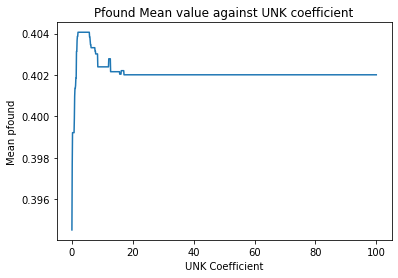

In [129]:
plt.plot(x, pfound_y)
plt.title("Pfound Mean value against UNK coefficient")
plt.xlabel("UNK Coefficient")
plt.ylabel("Mean pfound")

plt.show()

In [125]:
print(np.argmax(pfound_y))
print(max(pfound_y))

20
0.4040676980431723


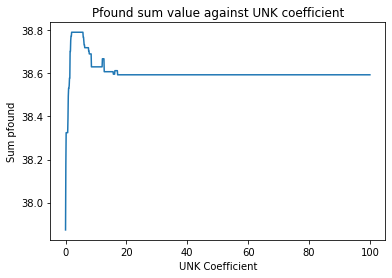

In [130]:
plt.plot(x, pfound_s_y)
plt.title("Pfound sum value against UNK coefficient")
plt.xlabel("UNK Coefficient")
plt.ylabel("Sum pfound")

plt.show()

In [126]:
print(np.argmax(pfound_s_y))
print(max(pfound_s_y))

20
38.790499012144515


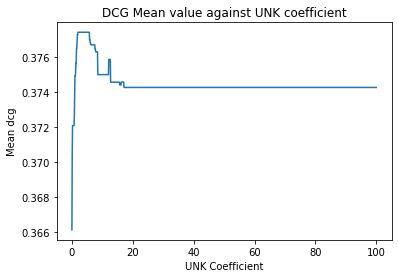

In [131]:
plt.plot(x, dcg_y)
plt.title("DCG Mean value against UNK coefficient")
plt.xlabel("UNK Coefficient")
plt.ylabel("Mean dcg")


plt.show()

In [127]:
print(np.argmax(dcg_y))
print(max(dcg_y))

20
0.3774197870814635


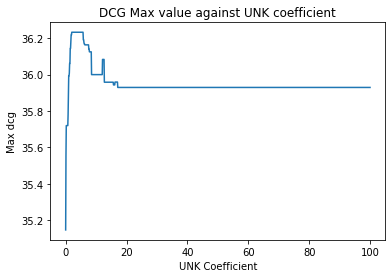

In [132]:
plt.plot(x, dcg_s_y)
plt.title("DCG Max value against UNK coefficient")
plt.xlabel("UNK Coefficient")
plt.ylabel("Max dcg")

plt.show()

In [128]:
print(np.argmax(dcg_s_y))
print(max(dcg_s_y))

20
36.23229955982049


In [133]:
x[20]

2.0118018018018016